In [1]:
import matplotlib.pyplot as plt
import keras
from keras import layers,models
import tensorflow as tf
import numpy as np
import joblib

In [2]:
IMG_SIZE=120
BATCH_SIZE=32

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("Dataset/plant/train/",seed=10,
                                                            batch_size=BATCH_SIZE,image_size=[IMG_SIZE,IMG_SIZE])

Found 804 files belonging to 5 classes.


In [4]:
class_names=dataset.class_names
joblib.dump(class_names,'crop_names.pkl')
print(class_names)

['jute', 'maize', 'rice', 'sugarcane', 'wheat']


<Figure size 720x720 with 0 Axes>

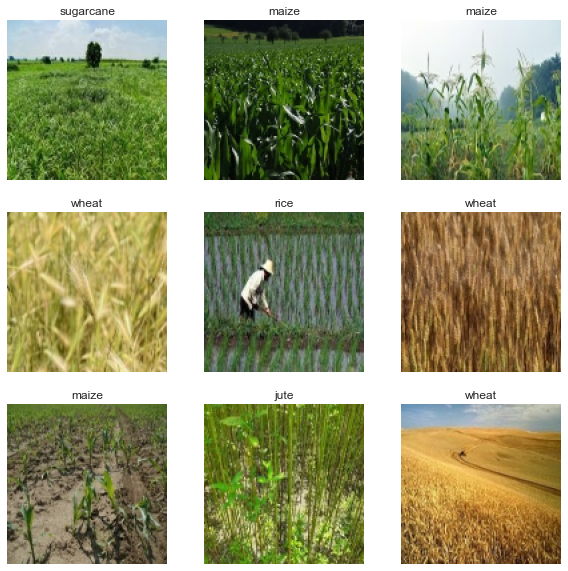

In [5]:
plt.figure(figsize=(10,10))
plt.style.use('seaborn')
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

In [6]:
print(len(dataset))


26


### Train Test Split

In [7]:
def test_train_split(dataset,train_per=0.8,valid_per=0.2):
    n=len(dataset)
    train_len=int(n*train_per)
    train_ds=dataset.take(train_len)
    data=dataset.skip(train_len)
#     test_len=int(n*test_per)
#     test_ds=data.take(test_len)
#     valid_ds=data.skip(test_len)
    return train_ds,data

In [8]:
train_ds,valid_ds=test_train_split(dataset,0.8,0.2)

In [5]:
test_ds=tf.keras.preprocessing.image_dataset_from_directory("Dataset/plant/test/",seed=10,
                                                            batch_size=BATCH_SIZE,image_size=[IMG_SIZE,IMG_SIZE])

Found 201 files belonging to 5 classes.


In [11]:
print(len(train_ds))
print(len(test_ds))
print(len(valid_ds))

20
7
6


In [12]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
vaidl_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### Augmentation

In [41]:
data_augmentation = models.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [42]:
input_shape=(BATCH_SIZE,IMG_SIZE,IMG_SIZE,3)
n_classes=len(dataset.class_names)
print(n_classes)

5


In [48]:

model=models.Sequential([
    layers.Resizing(IMG_SIZE,IMG_SIZE),
    layers.Rescaling(1.0/255),
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape,padding='same'),
    layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu',padding='same'),
    layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'),
    
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu',padding='same'),
    layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'),
    
    layers.Conv2D(32,  kernel_size = (3,3), activation='relu',padding='same'),
    layers.Dropout(0.2),
    layers.MaxPooling2D((2, 2),strides=(2,2),padding='same'),
    
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(n_classes, activation='softmax')
]
)

In [49]:
model.build(input_shape=input_shape)

In [50]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_5 (Resizing)       (32, 120, 120, 3)         0         
                                                                 
 rescaling_5 (Rescaling)     (32, 120, 120, 3)         0         
                                                                 
 sequential_6 (Sequential)   (None, 120, 120, 3)       0         
                                                                 
 conv2d_28 (Conv2D)          (32, 120, 120, 32)        896       
                                                                 
 max_pooling2d_28 (MaxPoolin  (32, 60, 60, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (32, 60, 60, 64)          18496     
                                                      

In [51]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [52]:
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=valid_ds,
    verbose=1,
    epochs=100,
)

Epoch 1/100
20/20 [==============================] - 11s 515ms/step - loss: 1.6202 - accuracy: 0.1891 - val_loss: 1.6018 - val_accuracy: 0.2195
Epoch 2/100
20/20 [==============================] - 10s 486ms/step - loss: 1.5626 - accuracy: 0.2500 - val_loss: 1.4529 - val_accuracy: 0.3415
Epoch 3/100
20/20 [==============================] - 11s 529ms/step - loss: 1.4819 - accuracy: 0.3344 - val_loss: 1.4047 - val_accuracy: 0.3354
Epoch 4/100
20/20 [==============================] - 11s 526ms/step - loss: 1.4155 - accuracy: 0.3703 - val_loss: 1.3783 - val_accuracy: 0.4878
Epoch 5/100
20/20 [==============================] - 10s 520ms/step - loss: 1.3571 - accuracy: 0.4219 - val_loss: 1.2294 - val_accuracy: 0.5183
Epoch 6/100
20/20 [==============================] - 11s 527ms/step - loss: 1.3126 - accuracy: 0.4500 - val_loss: 1.2578 - val_accuracy: 0.4939
Epoch 7/100
20/20 [==============================] - 10s 517ms/step - loss: 1.2530 - accuracy: 0.5078 - val_loss: 1.1601 - val_accuracy:

In [53]:
print(model.evaluate(test_ds))
print(model.evaluate(valid_ds))
print(model.evaluate(train_ds))

7/7 [==============================] - 1s 90ms/step - loss: 0.3206 - accuracy: 0.8955
[0.32059794664382935, 0.89552241563797]
6/6 [==============================] - 1s 85ms/step - loss: 0.2927 - accuracy: 0.9207
[0.29271796345710754, 0.9207317233085632]
20/20 [==============================] - 2s 98ms/step - loss: 0.2534 - accuracy: 0.9141
[0.25341665744781494, 0.9140625]


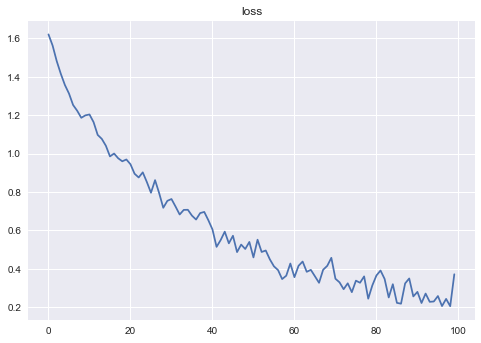

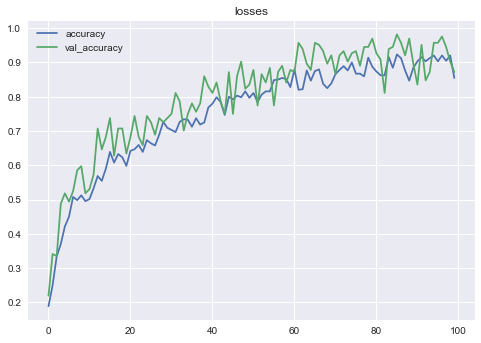

In [54]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.show()
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.title('losses')
plt.show()


model=models.Sequential([
    layers.Resizing(IMG_SIZE,IMG_SIZE),
    layers.Rescaling(1.0/255),
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
]
)

In [11]:
from keras.models import model_from_json
def predict(img):
    img=img.reshape(1,img.shape[0],img.shape[1],img.shape[2])
    json_file = open('crop_recognize.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("crop_recognize.h5")
    arr=loaded_model.predict(img)
    ind=np.argmax(arr)
    names=joblib.load('crop_names.pkl')
    return names[ind]

sugarcane


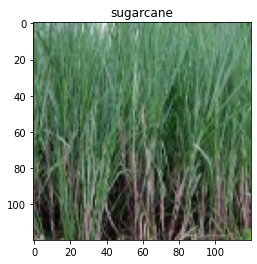

rice


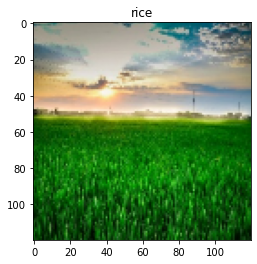

maize


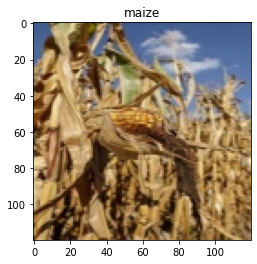

maize


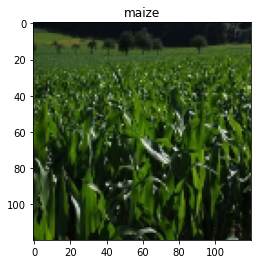

wheat


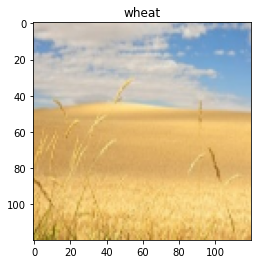

wheat


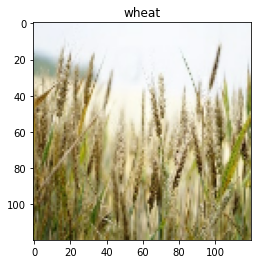

wheat


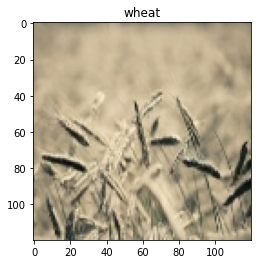

jute


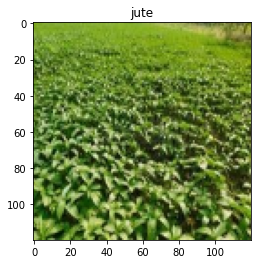

jute


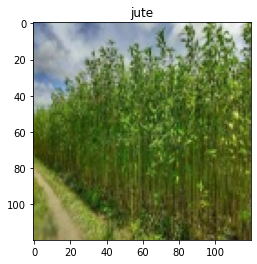

sugarcane


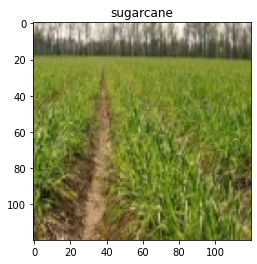

rice


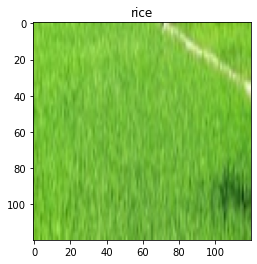

wheat


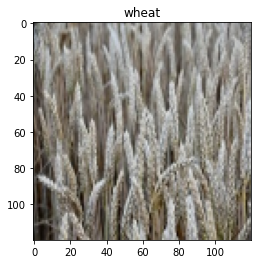

maize


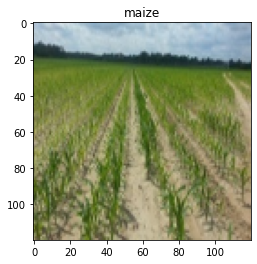

wheat


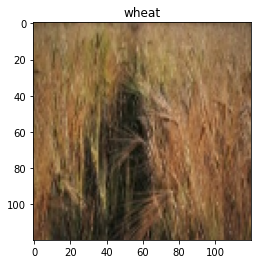

sugarcane


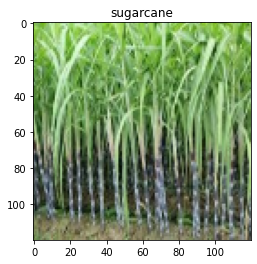

jute


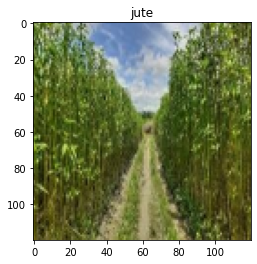

rice


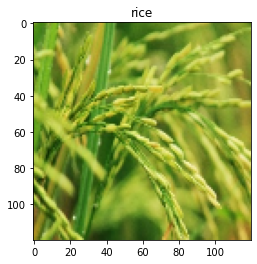

sugarcane


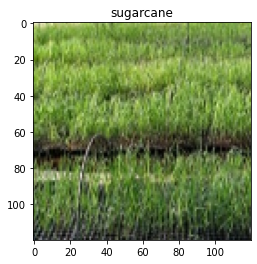

sugarcane


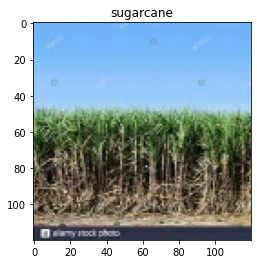

wheat


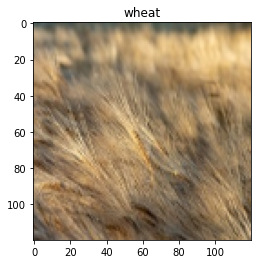

wheat


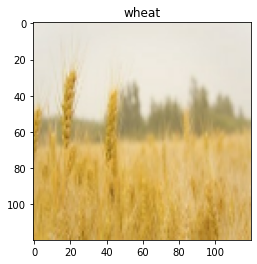

jute


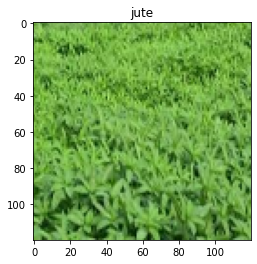

In [ ]:
for images,label in test_ds.take(1):
    for i in range(len(images)):
#         print(x.shape)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        print(predict(images[i].numpy()))
        plt.show()

        
    
    

In [10]:
from keras.models import model_from_json

In [58]:
model_json = model.to_json()
with open("crop_recognize.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("crop_recognize.h5")

In [59]:
json_file = open('crop_recognize.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("crop_recognize.h5")

In [60]:
print(type(model))

<class 'keras.engine.sequential.Sequential'>


In [61]:
print(type(loaded_model))

<class 'keras.engine.sequential.Sequential'>


In [62]:
loaded_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [63]:
print(loaded_model.evaluate(test_ds))
print(loaded_model.evaluate(valid_ds))
print(loaded_model.evaluate(train_ds))

7/7 [==============================] - 1s 98ms/step - loss: 0.3206 - accuracy: 0.8955
[0.32059794664382935, 0.89552241563797]
6/6 [==============================] - 1s 91ms/step - loss: 0.2401 - accuracy: 0.9146
[0.24005226790905, 0.9146341681480408]
20/20 [==============================] - 2s 105ms/step - loss: 0.2534 - accuracy: 0.9141
[0.25341665744781494, 0.9140625]


In [26]:
from PIL import Image

In [12]:
print(loaded_model.evaluate(test_ds))

1/1 [==============================] - 2s 2s/step - loss: 26.8653 - accuracy: 0.0000e+00
[26.865278244018555, 0.0]


In [33]:
im=Image.open("Dataset/plant_disease/test/Tomato__Septoria_leaf_spot/WhatsApp Image 2022-05-18 at 12.37.31 AM.jpeg")

In [34]:
im=im.resize((120,120))
im=np.array(im)

In [35]:
im.shape

(120, 120, 3)

In [36]:
print(predict(im))

Tomato___Septoria_leaf_spot


In [5]:
import cv2
import matplotlib.pyplot as plt

In [3]:
def load_image(file_path):
    bgr_img = cv2.imread(file_path)
    img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (120, 120))
    plt.imshow(img)    
    return img


array([[[ 47,  78,   1],
        [ 79, 116,   1],
        [ 92, 129,   2],
        ...,
        [201, 225, 254],
        [188, 188, 129],
        [105, 137,  94]],

       [[ 54,  87,   4],
        [ 68,  98,   9],
        [ 84, 121,  10],
        ...,
        [215, 232, 255],
        [217, 221, 243],
        [138, 168,  43]],

       [[ 49,  82,   2],
        [ 84, 118,   3],
        [106, 149,   3],
        ...,
        [215, 229, 251],
        [224, 232, 243],
        [223, 229, 255]],

       ...,

       [[ 67,  54,  39],
        [ 84,  62,  43],
        [ 71,  45,   9],
        ...,
        [ 78,  87,   4],
        [178, 144,  66],
        [ 84, 119,  45]],

       [[ 45,  39,  11],
        [ 67,  48,  31],
        [ 77,  53,  17],
        ...,
        [ 83,  86,   0],
        [158, 130,  59],
        [125, 127,  55]],

       [[ 51,  48,   1],
        [ 73,  53,  31],
        [ 68,  48,  15],
        ...,
        [ 87,  94,   0],
        [149, 122,  55],
        [114,  92,  35]]

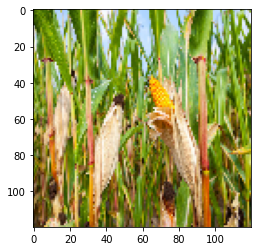

In [6]:
load_image('../../server/images/maize.jpeg')
